In [1]:
import requests
from bs4 import BeautifulSoup as bs
from tqdm import tqdm
import time
import os
import numpy as np
import nltk
import spacy
import string
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
import builtins
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import random
from wordcloud import WordCloud
from gensim.models import TfidfModel, Phrases, phrases, CoherenceModel
from gensim.corpora import Dictionary
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim.models.ldamodel as LDAModel
from gensim.test.utils import datapath
from gensim.corpora import MmCorpus
pyLDAvis.enable_notebook()
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Patrick\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Scraper
I scraped the data off of the Stanford Encyclopedia of Philosophy at random. I saved the body of each document to a text file.

In [2]:
"""
NUM_DOCS = 3000
directory = 'pages//'
docs = []

def clean_filename(filename):
    filename = unidecode(filename)
    bad_chars = ['‘', '\'']
    for char in bad_chars:
        if char in filename:
            print(filename)
            filename = filename.replace(char, '')
    return filename

while len(os.listdir('pages//')) < NUM_DOCS:
    # load a page
    url = 'https://plato.stanford.edu/cgi-bin/encyclopedia/random'
    page = requests.get(url)
    soup = bs(page.content, 'html.parser')
    
    # Locate the title and clean it up
    # Every title contains the name of the site, so that is removed
    # Forward slashes are replaced with dashes
    title = ' '.join(soup.title.text.strip('\n').split()[:-4]).replace('/', '-')
    title = clean_filename(title)
    # Save the body of the document
    if title not in docs:
        docs.append(title)
        body = soup.find('div', id='main-text')
        # A minority of pages did not have anything in the body
        if body:
            paragraphs = '\n'.join([paragraph.text.strip('\n') for paragraph in body.find_all('p')])
            with open(f'{directory+title}.txt', 'w', encoding='utf8') as f:
                for paragraph in paragraphs:
                    f.write(paragraph)
    count = len(os.listdir('pages//'))
    if not count % 500:
        print(count)
    
    
    # sleep to be nice
    time.sleep(3)"""

"\nNUM_DOCS = 3000\ndirectory = 'pages//'\ndocs = []\n\ndef clean_filename(filename):\n    filename = unidecode(filename)\n    bad_chars = ['‘', ''']\n    for char in bad_chars:\n        if char in filename:\n            print(filename)\n            filename = filename.replace(char, '')\n    return filename\n\nwhile len(os.listdir('pages//')) < NUM_DOCS:\n    # load a page\n    url = 'https://plato.stanford.edu/cgi-bin/encyclopedia/random'\n    page = requests.get(url)\n    soup = bs(page.content, 'html.parser')\n    \n    # Locate the title and clean it up\n    # Every title contains the name of the site, so that is removed\n    # Forward slashes are replaced with dashes\n    title = ' '.join(soup.title.text.strip('\n').split()[:-4]).replace('/', '-')\n    title = clean_filename(title)\n    # Save the body of the document\n    if title not in docs:\n        docs.append(title)\n        body = soup.find('div', id='main-text')\n        # A minority of pages did not have anything in the b

# Read in the Documents

In [3]:
doc_dir = 'pages//'
doc_locations = []
for file in os.listdir(doc_dir):
    if file.split('.')[-1] == 'txt':
        doc_locations.append(doc_dir+file)

In [4]:
raw_docs = []
for loc in doc_locations:
    with open(loc, encoding='utf8') as f:
        raw_docs.append('\n'.join(f.readlines()))
print(f'There are {len(raw_docs)} documents')

There are 1730 documents


# Tokenization
Documents are split into tokens, with each word being a token.

In [5]:
tokenizer = nltk.tokenize.word_tokenize
tokenized_docs = [tokenizer(doc) for doc in tqdm(raw_docs)]

100%|██████████| 1730/1730 [01:14<00:00, 23.15it/s]


# Lemmatization
A lemma is the "base" form of a word given the word's part of speech. For example, the lemma of "running" is "run," the lemma of "cares" is "care" and so on. Lemmatization reduces words to their lemmas. Since lemmatization is part of speech dependent, each word must first be tagged with its part of speech.

I use lemmatization here because I am only introduced in the meaning of words regardless of their form. For example, the difference between "cares," "caring," "cared" and so on are meaningless for this application. An added bonus is that lemmatization will reduce the number of unique words in the text.

Note when tagging the part of speech, there is a catch all category of words that are not lemmatized. This catches tokens that would not be lemmatized anyway like numbers, conjunctions and determiners ("all," "every," etc.).

In [6]:
lemmatized_docs = []
lemmatizer = WordNetLemmatizer()

# Takes an untagged document, a sequence of tokens, tags each token in the
# document with a part of speech, and converts those tags into a form that
# the lemmatizer can use.
# Returns a tagged document, a list of tuples in the form (token, PoS)
def tagger(untagged_doc):
    tagged_doc = nltk.pos_tag(untagged_doc)
    formatted_tags = []
    for tok in tagged_doc:
        unformatted_tag = tok[1]
        # Convert POS tags into format usable by nltk
        if unformatted_tag.startswith('N'):
            formatted_tag = wordnet.NOUN
        elif unformatted_tag.startswith('V'):
            formatted_tag = wordnet.VERB
        elif unformatted_tag.startswith('R'):
            formatted_tag = wordnet.ADV
        elif unformatted_tag.startswith('J'):
            formatted_tag = wordnet.ADJ
        # The
        else:
            formatted_tag = unformatted_tag
        formatted_tags.append((tok[0], formatted_tag))
    return formatted_tags
        
    
pos_to_lemmatize = [wordnet.NOUN, wordnet.VERB, wordnet.ADV, wordnet.ADJ]
lemmatized_docs = []

# Select a subset of documents - helps with memory problems
#num_docs = 875
#random.shuffle(tokenized_docs)
#tokenized_docs = tokenized_docs[:num_docs]
#print(f'Selected {num_docs} documents')

# Tag and lemmatize each document
for tokenized_doc in tqdm(tokenized_docs):
    # POS tagging
    tagged_doc = tagger(tokenized_doc)
    # Lemmatization
    lemmatized_doc = [lemmatizer.lemmatize(tok[0], tok[1]) for tok in tagged_doc if tok[1] in pos_to_lemmatize]
    lemmatized_docs.append(lemmatized_doc)

print(f'Lemmatized {len(lemmatized_docs)} documents')

100%|██████████| 1730/1730 [06:48<00:00,  4.24it/s]

Lemmatized 1730 documents


# Remove Stopwords, Punctuation, LaTeX, and Short Words.
The guiding principle has been that I only want to keep meaningful words. As such, I remove the following categories:
* Stopwords: words that are commonly used to the point of meaninglessness (ex. "the," "is")
* Punctuation: Not words and not meaningful
* LaTeX: Not words and not meaningful
* Short words: Unlikely to be meaningful. Most should be caught when removing stopwords, but there may be, for example, variables used in the text (ex. "If X is true").

In [7]:
# SEP has a lot of equations, etc. This helper function will help remove them.
def not_latek(tok):
    bad_chars = string.punctuation
    # Don't want to catch, for example eighteenth-century
    bad_chars = bad_chars.replace('-','')
    for char in bad_chars:
        if char in tok:
            return False
    return True


In [8]:
clean_docs = []
min_tok_length = 3
stopwords = nltk.corpus.stopwords.words('english')
stopwords += string.punctuation
stopwords += ["often", "happen", "later", "hardly", "leave", "proceed", "anything", "make", "take", "different", "something", "others", "word", "also", "give",
             "take", "term", "view", "thus", "kind", "many", "seem", "call", "well", "consider", "case", "point", "rather", "possible", "seem", "even", "thing",
             "vein", "grasped", "rather", "hardly", "onwards", "anything", "think", "need", "know", "example", "however", "hold", "much", 'theory']
bad_toks = set()
for doc in lemmatized_docs:
    clean_doc = []
    for tok in doc:
        if len(tok) > min_tok_length and tok not in stopwords and not_latek(tok):
            clean_doc.append(tok.lower())
    clean_docs.append(clean_doc)

# Data Exploration

In [9]:
corpus = []
for doc in tqdm(clean_docs):
    corpus += doc
print(f'Combined the {len(clean_docs)} docs into a single list of {len(corpus)} words.')


100%|██████████| 1730/1730 [00:00<00:00, 12405.75it/s]

Combined the 1730 docs into a single list of 8399883 words.


## Document Length

The mean article length is 4855 words.
The shortest article is 55 and the longest is 40264 words.


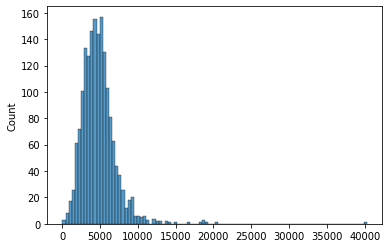

In [10]:
lengths = [len(doc) for doc in clean_docs]
sns.histplot(lengths)

print(f'The mean article length is {int(np.mean(lengths))} words.')
print(f'The shortest article is {np.min(lengths)} and the longest is {np.max(lengths)} words.')

 ## Word Frequencies
 Here, I visualize the 20 most used words across the corpus. This acts as a nice sanity check after processing the data, making sure that most of the top words are meaningful.

<AxesSubplot:>

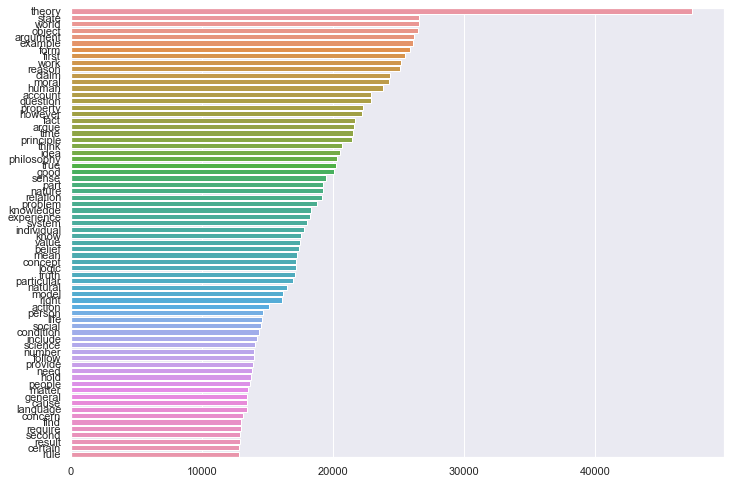

In [11]:
counter = Counter(corpus)
most_common = counter.most_common()

x = []
y = []

sns.set(rc={'figure.figsize':(11.7,8.27)})

for word, count in most_common[:70]:
    x.append(word)
    y.append(count)
sns.barplot(x=y, y=x, orient='h')

Most of the top words are the sort of meaningful words one would expect in a philosophy website. Some are fairly generic (ex. "also" and "take"), but they are the minority. I am not concerned with them unless they are over-represented as relevant terms in the LDA model.

# Word Cloud

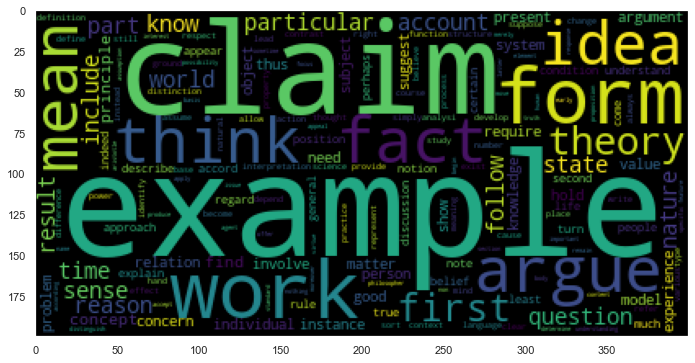

In [12]:
wc = WordCloud()
wc.generate(' '.join(corpus))
plt.imshow(wc)
plt.grid(None)

# Tf-Idf Models
Term-Frequency-Inverse Document Frequency gives a score that quantifies the  importance of certain words. The score for a word increases for the number of times the word is used in the document, but decreases as the word is used more across different documents in the corpus. As such, terms will have higher scores if they are used frequently in relatively few documents, and those terms will presumably be important.

## Learning Bigrams
An n-gram is a sequence of n consecutive tokens. For the sake of this analysis I consider the most common unigrams (single words, above) and bigrams. I will lose information about word order by using a bag of word model, so grouping together consecutive tokens will prove useful.

As a rule of thumb, a bigram has a more specific meaning than a unigram. For example the word "ninth" tells us little to nothing - this could be in a context like "ninth place" or "ninth person." "Ninth century" will be found in fewer contexts.

There is no inherent reason to stop at bigrams; however, even a trigram analysis is fruitless here.To generate bigrams, I use gensim's Phrases module, which attempts to learn useful bigrams, rather than finding every bigram in a text. I also attempt to find trigrams using the library, but am unable to do so, even with the model tuned liberally.

In [13]:
bigram_phrases = Phrases(clean_docs, min_count=1, threshold=10)

bigram = phrases.Phraser(bigram_phrases)

trigram = phrases.Phrases(bigram[clean_docs], min_count=1, threshold=10)

In [14]:
bigrams = []
bigrams_trigrams_docs = []
trigrams = []

# Find bigrams and trigrams in each document
for doc in clean_docs:
    bigrams_trigrams_doc = []
    for i in trigram[doc]:
        if len(i.split("_")) == 2:
            bigrams.append(i)
            bigrams_trigrams_doc.append(i)
        elif len(i.split("_")) == 3:
            trigrams.append(i)
            bigrams_trigrams_doc.append(i)
        else:
            bigrams_trigrams_doc.append(i)
    bigrams_trigrams_docs.append(bigrams_trigrams_doc)
print(f'Learned {len(set(bigrams))} bigrams and {len(set(trigrams))} trigrams.')


Learned 209126 bigrams and 0 trigrams.


In [15]:
trigrams

[]

An immediate concern here is that, even with parameters set to be very accepting of phrases, we learn no trigrams. 

<AxesSubplot:>

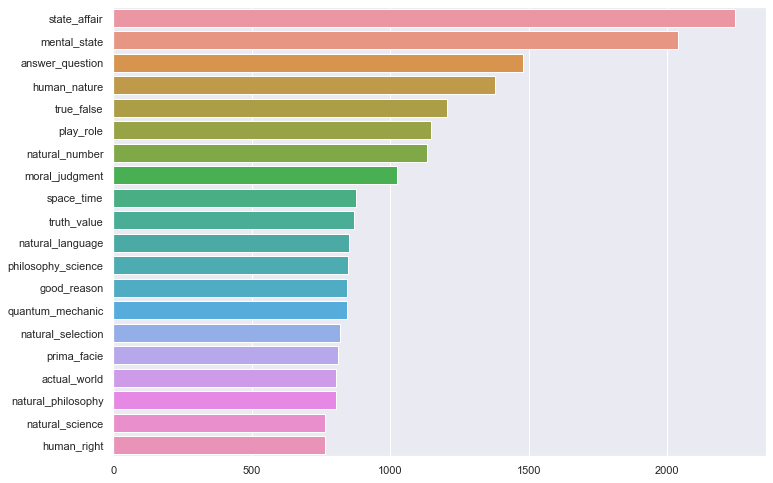

In [16]:
TOP_X = 20

counter = Counter(bigrams)
most_common = counter.most_common()[:20]

x = [tup[0] for tup in most_common]
y = [tup[1] for tup in most_common]

sns.barplot(x=y, y=x, orientation='horizontal')

The bigrams are somewhat promising with respect to their potential to discriminate between topics. Some of the topics have obviously topic-specific menaings like philosophy_science (philosophy of science) or truth_value (logic).

### Bag of Words Vectorization
A bag of words vectorization is a vector representation of a document (or sentence, paragraph, etc.) that does not take into account token order. Each document is represented as a vector with dimensionality equivalent to the size of the number of unique words in the corpus. Each component in the vector represents a token, and the magnitude of the component represents how many times the token is used in the document.

In [17]:
if 'bigram_bow.mm' not in os.listdir():
    # Create bigram dictionary
    bigram_dictionary = Dictionary(bigrams_trigrams_docs)
    bigram_dictionary.save_as_text('bigram_dict.txt')

    # Create bag of words models from the bigram representations of the documents
    bigram_bow = [bigram_dictionary.doc2bow(doc) for doc in tqdm(bigrams_trigrams_docs)]

    MmCorpus.serialize('bigram_bow.mm', bigram_bow)
else:
    bigram_bow = MmCorpus('bigram_bow.mm')
    bigram_dictionary = Dictionary.load_from_text('bigram_dict.txt')

### Building the Tf-Idf Model

In [18]:
# Create the model
tfidf_bigram = TfidfModel(corpus=bigram_bow, id2word=bigram_dictionary)

#### Visualize tf-idf Score Distribution
Here, I visualize the tf-idf score, so I can pick a reasonable score, below which words will be disposed. Note that this distribution has a very long tail. The limits placed on the x-axis cut off some outliers.

  0%|          | 0/1730 [00:02<?, ?it/s]


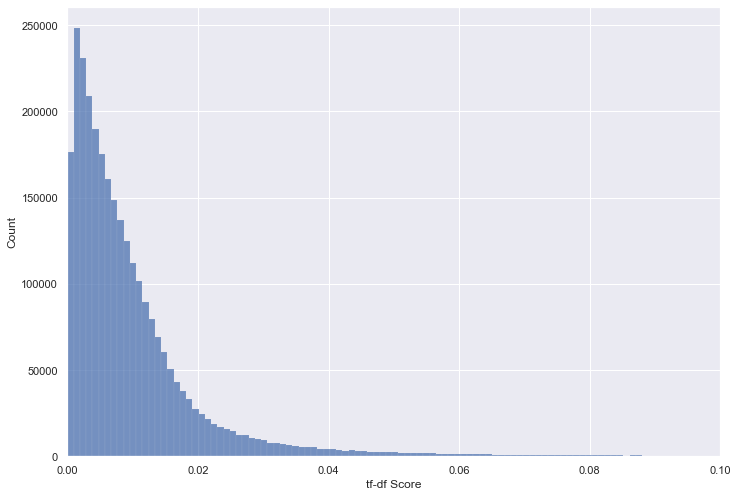

In [19]:
scores = []
idx = []
corpus_length = len(bigram_bow)
bigram_bow = list(bigram_bow)
with tqdm(total=corpus_length, position=0, leave=True) as pbar:
    for i in tqdm(range(corpus_length), position=0, leave=True):
    #for i in range(len(bigram_bow[:10])):
        bow = bigram_bow[i]
        tfidf = tfidf_bigram[bow]
        for tup in tfidf:
            idx.append(tup[0])
            scores.append(tup[1])
        
hist = sns.histplot(scores,bins=1000)
hist.set(xlim=(0,0.1))
hist.set_xlabel('tf-df Score')
plt.show()

In [20]:
cutoff = 0.02
words = []
missing_words = []
corpus_length = len(bigram_bow)
tf_idf_bow = []
if 'tf_idf_bow.mm' not in os.listdir():
    # Create new bag of words representations of each document, keeping
    # only words above a certain score.
    with tqdm(total=corpus_length, position=0, leave=True) as pbar:
        for i in tqdm(range(corpus_length), position=0, leave=True):
            bow = bigram_bow[i]
            # This list holds all the words
            tfidf_idxs = []
            # This list holds the words with scores below the threshold
            low_val_words = []
            # This list holds the words to keep in the model
            bow_idxs = []
            for idx, value in tfidf_bigram[bow]:
                tfidf_idxs.append(idx)
                if value < cutoff:
                    low_val_words.append(idx)
                else:
                    bow_idxs.append(idx)
            dropped = low_val_words + missing_words
            for item in dropped:
                words.append(bigram_dictionary[item])
            # Missing words are words with zero score
            missing_words = [idx for idx in bow_idxs if idx not in tfidf_idxs]
            # Keeps words above score threshold
            new_bow = [w for w in bow if w[0] not in low_val_words and w[0] not in missing_words]    
            tf_idf_bow.append(new_bow)
        MmCorpus.serialize('tf_idf_bow.mm', tf_idf_bow)
else:
    tf_idf_bow = MmCorpus('tf_idf_bow.mm')
    

# LDA Models

# Unigram

# Bigrams

### Model

### Tune Topics

In [63]:
# Given a number of topics, trains an LDA model if one has not been saved
# Otherwise, loads an equivalent LDA model.
# Returns the LDA model.
def train_lda(topics):
    data_size_folder = f"{len(bigram_bow)} Documents"
    # Use the same name for model folders and files
    model_folder_file = f"lda_model_{len(bigram_bow)}_{topics}"
    
    # Check if any models for a corpus of this size have been saved
    # If not, make a folder to store those models
    if data_size_folder not in os.listdir():
        print(f'Making directory for corpus with {len(bigram_bow)} documents.')
        os.mkdir(data_size_folder)
        
    # Check if any models with a given number of topics have been saved for a corpus of this size
    # If not, make a folder to store the model, train the model, and save it
    if model_folder_file not in os.listdir(data_size_folder):
        print(f'Training a model with {topics} topics on a corpus with {len(bigram_bow)} documents.')
        os.mkdir(os.path.join(data_size_folder, model_folder_file))
        model_loc = os.path.join(data_size_folder,  model_folder_file, model_folder_file)
        lda_model = LDAModel.LdaModel(corpus=tf_idf_bow,
                                                   id2word=bigram_dictionary,
                                                   num_topics=topics,
                                                   iterations=1000,
                                                   chunksize=300,
                                                   update_every=0,
                                                   passes=300,
                                                   alpha='auto',
                                                   eta='auto',
                                                   random_state=123)
        lda_model.save(model_loc)
    else:
        print(f'Loading trained model for model with {topics} topics.')
        lda_model = LDAModel.LdaModel.load(os.path.join(data_size_folder, model_folder_file, model_folder_file))
    return lda_model


### Coherence by topic

In [65]:
lda_by_topic = [train_lda(i) for i in range(2,16)]

Making directory for corpus with 1730 documents.
Training a model with 2 topics on a corpus with 1730 documents.
Training a model with 3 topics on a corpus with 1730 documents.
Training a model with 4 topics on a corpus with 1730 documents.
Training a model with 5 topics on a corpus with 1730 documents.
Training a model with 6 topics on a corpus with 1730 documents.
Training a model with 7 topics on a corpus with 1730 documents.
Training a model with 8 topics on a corpus with 1730 documents.
Training a model with 9 topics on a corpus with 1730 documents.
Training a model with 10 topics on a corpus with 1730 documents.
Training a model with 11 topics on a corpus with 1730 documents.
Training a model with 12 topics on a corpus with 1730 documents.
Training a model with 13 topics on a corpus with 1730 documents.
Training a model with 14 topics on a corpus with 1730 documents.
Training a model with 15 topics on a corpus with 1730 documents.


In [66]:

# Takes a model
# Returns the model's CV score
def coherence_score(lda_model):
    coherence_model = CoherenceModel(model=lda_model,
                                        corpus=tf_idf_bow,
                                        texts=clean_docs,
                                        coherence='u_mass',
                                        window_size=500,
                                        processes=1)
    with np.errstate(invalid='ignore'):
        score = coherence_model.get_coherence()
    return score

scores = [coherence_score(model) for model in tqdm(lda_by_topic)]

100%|██████████| 14/14 [00:01<00:00,  8.70it/s]


In [67]:
scores

[-5.5200642505256585,
 -6.193734279008105,
 -6.815810846985374,
 -7.218598236863187,
 -7.07184257167781,
 -7.265505074444895,
 -7.514641087758612,
 -7.713267390791223,
 -8.474012760296947,
 -8.92418063598027,
 -8.77783065601273,
 -9.539670637964935,
 -9.555912246486473,
 -10.168141612043586]

C:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

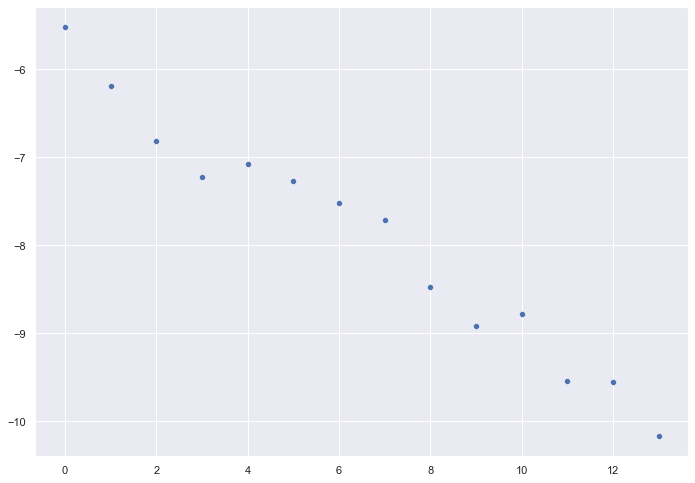

In [68]:
sns.scatterplot(range(len(scores)), scores)

### Visualization model

In [ ]:
tf_idf_idxs = []
for doc in list(tf_idf_bow):
    for vec in doc:
        tf_idf_idxs.append(vec[0])
tf_idf_idxs = list(set(tf_idf_idxs))

In [51]:
lda_model = lda_by_topic[2]
topics = lda_model.get_topics().shape[0] +2

In [52]:
vis = gensimvis.prepare(lda_model,
                       tf_idf_bow,
                       bigram_dictionary,
                       mds='mmds',
                       R=30)
vis

C:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.176098 -0.130482       1        1  31.244621
3     -0.126842  0.193800       2        1  27.953688
0      0.121635 -0.181487       3        1  23.608323
1      0.181305  0.118170       4        1  17.193367, topic_info=                           Term         Freq        Total Category  logprob  \
142282            habit_acquire  3995.000000  3995.000000  Default  30.0000   
48101           causation-model  3735.000000  3735.000000  Default  29.0000   
164971  instantiate_disjunctive  2013.000000  2013.000000  Default  28.0000   
312120            socialization  3494.000000  3494.000000  Default  27.0000   
338174                 thinking  3646.000000  3646.000000  Default  26.0000   
...                         ...          ...          ...      ...      ...   
308395                  similar   248.180241  1530.049354   Topic4  -6.4992   
52215                      chos   246.623303  1678.138419   Topic4  -6.5055   
74084       criminality—arguing   209.156125   496.126763   Topic4  -6.6702   
6650                 adaptation   229.278564  2124.512083   Topic4  -6.5784   
64463              confucianism   234.721599  3286.969442   Topic4  -6.5549   

        loglift  
142282  30.0000  
48101   29.0000  
164971  28.0000  
312120  27.0000  
338174  26.0000  
...         ...  
308395  -0.0583  
52215   -0.1569  
74084    0.8969  
6650    -0.4657  
64463   -0.8787  

[326 rows x 6 columns], token_table=        Topic      Freq                   Term
term                                          
235         2  0.999412            -extensible
2026        2  0.190810           a-properties
2026        3  0.519830           a-properties
2026        4  0.289117           a-properties
6650        1  0.227817             adaptation
...       ...       ...                    ...
366559      2  0.997333  willingness_cooperate
368032      1  0.078398              word_deed
368032      3  0.919872              word_deed
368171      1  0.087827             words—true
368171      3  0.912202             words—true

[586 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

In [ ]:
# Good topic numbers
# 12!!!!!
# 10
# 6

In [ ]:
bigram_bow[0]

[(0, 1),
 (1, 1),
 (2, 2),
 (3, 1),
 (4, 5),
 (5, 5),
 (6, 1),
 (7, 7),
 (8, 4),
 (9, 9),
 (10, 1),
 (11, 1),
 (12, 2),
 (13, 2),
 (14, 1),
 (15, 5),
 (16, 7),
 (17, 2),
 (18, 2),
 (19, 4),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 2),
 (24, 2),
 (25, 1),
 (26, 4),
 (27, 2),
 (28, 1),
 (29, 18),
 (30, 3),
 (31, 1),
 (32, 1),
 (33, 1),
 (34, 5),
 (35, 1),
 (36, 1),
 (37, 1),
 (38, 1),
 (39, 2),
 (40, 1),
 (41, 2),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 6),
 (46, 12),
 (47, 1),
 (48, 1),
 (49, 6),
 (50, 1),
 (51, 2),
 (52, 4),
 (53, 1),
 (54, 3),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 1),
 (59, 1),
 (60, 18),
 (61, 7),
 (62, 1),
 (63, 2),
 (64, 1),
 (65, 5),
 (66, 8),
 (67, 10),
 (68, 1),
 (69, 1),
 (70, 3),
 (71, 1),
 (72, 1),
 (73, 2),
 (74, 1),
 (75, 1),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 3),
 (81, 2),
 (82, 1),
 (83, 8),
 (84, 2),
 (85, 1),
 (86, 3),
 (87, 5),
 (88, 1),
 (89, 6),
 (90, 2),
 (91, 1),
 (92, 3),
 (93, 2),
 (94, 1),
 (95, 2),
 (96, 3),
 (97, 14),
 (98, 2),
 (99, 2),
 (100